In [19]:
import json
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from bs4 import BeautifulSoup
import xml.etree.ElementTree as et
import xmltodict
from datetime import timedelta

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/OhioT1/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/OhioT1/'
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

In [25]:
def loadingDataReader(fileAddress):
    xmlTree = et.parse(fileAddress)
    xmlRoot = xmlTree.getroot()
    patientId=xmlRoot.attrib
    patientId=patientId['id']
    data=[]
    for parameter in xmlRoot:
        parameterName=parameter.tag
        for element in parameter:
            temporary=element.attrib
            if 'ts_begin' in temporary:
                tStartTemp=temporary['ts_begin']
            elif 'ts' in temporary:
                tStartTemp=temporary['ts']
            elif 'tbegin' in temporary:
                tStartTemp=temporary['tbegin']
            tStart = datetime.strptime(tStartTemp, '%d-%m-%Y %H:%M:%S')

            if 'ts_ebd' in temporary:
                tEndTemp=temporary['ts_end']
                tEnd = datetime.strptime(tEndTemp, '%d-%m-%Y %H:%M:%S')
            elif 'tend' in temporary:
                tEndTemp=temporary['tend']
                tEnd = datetime.strptime(tEndTemp, '%d-%m-%Y %H:%M:%S')
            elif 'duration' in temporary:
                tEnd=tStart+timedelta(minutes=int(temporary["duration"]))
            else:
                tEnd=tStart

            if 'value' in temporary:
                val=float(temporary['value'])
            elif 'dose' in temporary:
                val=float(temporary['dose'])
            elif 'carbs' in temporary:
                val=float(temporary['carbs'])
            elif 'quality' in temporary:
                val=float(temporary['quality'])
            elif 'intensity' in temporary:
                val=float(temporary['intensity'])

            extra=''
            if 'bwz_carb_input' in temporary:
                extra=float(temporary['bwz_carb_input'])
            elif 'type' in temporary:
                extra=temporary['type']

            data.append([patientId,parameterName,tStart,tEnd,val,extra])
    df = pd.DataFrame(data, columns = ["Patient","Parameter", "Start","End","Value","Extra"])
    df.sort_values(by=['Parameter', 'Start'],inplace=True)
    return df

def loadingDataAux(addressPrefix):
    dfTotal = pd.DataFrame(columns = ["Patient","Parameter", "Start","End","Value","Extra"])
    os.chdir(addressPrefix)
    dataFiles=[]
    for root,dirs,files in os.walk(".", topdown=False):
       for file in files:
           if '.xml' in file:
               temporary=os.path.normpath(os.path.join(addressPrefix,root,file))
               dataFiles.append(temporary)
    for file in dataFiles:
        df=loadingDataReader(file)
        print("completed:",file)
        dfTotal = pd.concat([dfTotal, df],axis=0)
    dfTotal.sort_values(by=['Patient','Parameter','Start'],inplace=True)
    return dfTotal

df=loadingDataAux(addressPrefix)
df.to_csv(os.path.join(addressPrefix,'AllData.csv'))

559 glucose_level {'ts': '18-01-2022 00:01:00', 'value': '179'}
559 finger_stick {'ts': '18-01-2022 06:26:05', 'value': '294'}
559 basal {'ts': '18-01-2022 04:00:00', 'value': '0.73'}
559 temp_basal {'ts_begin': '19-01-2022 20:49:00', 'ts_end': '20-01-2022 04:11:00', 'value': '0.0'}
559 bolus {'ts_begin': '18-01-2022 06:26:05', 'ts_end': '18-01-2022 06:26:05', 'type': 'normal', 'dose': '6.3', 'bwz_carb_input': '40'}
559 meal {'ts': '18-01-2022 05:45:00', 'type': 'Breakfast', 'carbs': '46'}
559 sleep {'ts_begin': '18-01-2022 05:30:00', 'ts_end': '17-01-2022 21:30:00', 'quality': '3'}
559 work {'ts_begin': '18-01-2022 13:30:00', 'ts_end': '18-01-2022 13:30:00', 'intensity': '5'}
559 illness {'ts_begin': '21-01-2022 04:45:00', 'ts_end': '', 'type': '', 'description': ' '}
559 exercise {'ts': '18-01-2022 16:55:00', 'intensity': '5', 'type': ' ', 'duration': '57', 'competitive': ''}
559 basis_heart_rate {'ts': '18-01-2022 00:00:00', 'value': '57'}
559 basis_gsr {'ts': '18-01-2022 00:01:00',

In [ ]:
def dataResEnhancer(df):
    gapLength=1
    df=df.sort_values(by=['Parameter', 'Date','Time'])
    gapList=[]

    highResSensor=['Acc','EDA','HR','Temp','CGM']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter+1,0]:
                if newQuery.iloc[counter+1,1]-newQuery.iloc[counter,1]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter+1,1],newQuery.iloc[counter,3]])
    appendedData=[]
    for element in gapList:
        duration= element[2]-element[1]
        if duration%gapLength==0:
            fillerNumber=int(duration/gapLength-1)
        else:
            fillerNumber=int(duration/gapLength)
        for counter in range(0,fillerNumber):
            appendedData.append([element[0],element[1]+(counter+1)*gapLength,float('nan'),element[3]])

    df = df.append(pd.DataFrame(appendedData,columns=['Date','Time','Value','Parameter']),ignore_index = True)
    df=df.sort_values(by=['Parameter','Date','Time'])

    df=df.interpolate(method='linear')
    return df

def dataCleaner(df):
    i = df[df.Date == 30].index #first data and noisy
    df=df.drop(i)

    i = df[df.Date == 40].index #Partial E4
    df=df.drop(i)

    i = df[df.Date == 41].index #No E4
    df=df.drop(i)

    i = df[df.Date >= 42].index #CGM becomes too noisy at the end of the study
    df=df.drop(i)

    return df

def dataAmputator(df):
    amputations=[[31,38290,39010],[31,61937,62638],[31,66226,71099],
              [32,58667,59563],[32,63875,63902],
              [33,25127,34731],[33,57996,58812],
              [34,25556,30763],[34,58736,59877],[34,66069,66092],
              [35,27945,31416],[35,57283,58147],
              [36,29865,33926],[36,59231,60096],
              [37,26911,32544],[37,40214,41380],
              [38,26707,34560],[38,38172,39273],
              [39,31053,35335],[39,57408,58655]]

    for amputation in amputations:
        i=df[(df['Date']==amputation[0]) & (df['Time']>=amputation[1]) & (df['Time']<=amputation[2])].index
        df.loc[i,'Value']=float('nan')
        # df=df.drop(i)

    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result-interpolated.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        dfOriginal = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),
                          columns =['Date','Time','Value','Parameter'])
        dfOriginal=dfOriginal.sort_values(by=['Parameter','Date','Time'])
        dfOriginal.to_csv(addressPrefix+'Result-original.csv', header=True,index=False)
        print("Result-Original is saved")
        dfInterp=dataCleaner(dfOriginal)
        dfInterp=dataResEnhancer(dfInterp)
        dfInterp=dataAmputator(dfInterp)
        dfInterp.to_csv(addressPrefix+'Result-interpolated.csv', header=True,index=False)
        print("Result-Interpolated is saved")
    else:
        dfOriginal=pd.read_csv(addressPrefix+'Result-original.csv')
        dfInterp=pd.read_csv(addressPrefix+'Result-interpolated.csv')
    return dfOriginal,dfInterp

# dfOriginal,dfInterp=loadingData(addressPrefix)


Lag time= -2.0 Mean pearson= 0.129
[ 0.863  0.394  0.012 -0.796 -0.851 -0.292  0.383  0.943  0.502]
----------------------
Lag time= -1.5 Mean pearson= -0.315
[-0.374  0.103 -0.536 -0.328 -0.6   -0.411 -0.199 -0.38  -0.111]
----------------------
Lag time= -1.0 Mean pearson= -0.414
[-0.663 -0.74  -0.396 -0.326  0.133 -0.427 -0.615 -0.594 -0.1  ]
----------------------
Lag time= -0.5 Mean pearson= -0.155
[-0.29  -0.236 -0.462 -0.052  0.589 -0.353 -0.44  -0.017 -0.136]
----------------------
Lag time= 0.0 Mean pearson= 0.113
[-0.251  0.351  0.734  0.597 -0.48   0.034  0.789 -0.418 -0.342]
----------------------
Lag time= 0.5 Mean pearson= 0.174
[ 0.035  0.458  0.244  0.844 -0.62   0.664 -0.388 -0.097  0.426]
----------------------
Lag time= 1.0 Mean pearson= 0.125
[-0.549  0.469  0.243 -0.166 -0.123  0.306 -0.301  0.469  0.774]
----------------------
Lag time= 1.5 Mean pearson= -0.068
[-0.52  -0.355  0.648 -0.68  -0.365  0.353  0.706 -0.079 -0.321]
----------------------
Lag time= 2.0 Me

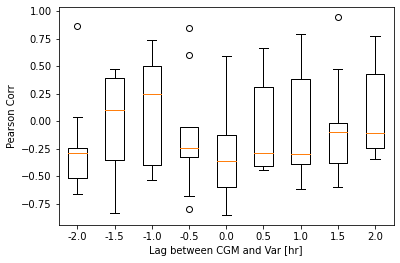

In [21]:
windowDuration=2
lagTimes=np.arange(-2,2.5,0.5)
mealTimes=[12.33,12.33,12.33,12.16,11.92,12.5,12.16,11.33,12.25]
plotFlag=False
plotParamter='Temp'

pearsonRatios=[]
days=dfInterp['Date']
days=days.values.tolist()
days=set(days)
days=list(days)
days.sort()
pearsonRatios=np.zeros((len(lagTimes),len(days)))
for i,lagTime in enumerate(lagTimes):
    for counter,day in enumerate(days):
        mealTime=mealTimes[counter]
        queryCGM=dfInterp[dfInterp['Date']==day]
        queryCGM['Time']=queryCGM['Time']/3600
        queryCGM=queryCGM[queryCGM['Parameter']=='CGM']
        queryCGM=queryCGM[queryCGM['Time']<=(mealTime+windowDuration)]
        queryCGM=queryCGM[queryCGM['Time']>=mealTime]

        queryVar=dfInterp[dfInterp['Date']==day]
        queryVar['Time']=queryVar['Time']/3600
        queryVar=queryVar[queryVar['Parameter']==plotParamter]
        queryVar=queryVar[queryVar['Time']<=(mealTime+windowDuration+lagTime)]
        queryVar=queryVar[queryVar['Time']>=(mealTime+lagTime)]
        if plotFlag:
            fig, ax1 = plt.subplots ()
            ax2 = ax1.twinx ()

            queryCGM.plot(ax=ax1,x='Time',y='Value',color='green')
            ax1.tick_params (axis='y', labelcolor='green')

            queryVar.plot(ax=ax2,x='Time',y='Value',color='red')
            ax2.tick_params (axis='y', labelcolor='red')

            ax1.set_ylabel('CGM')
            ax1.set_xlabel('Day')
            ax1.yaxis.label.set_color("green")

            ax2.set_ylabel(plotParamter)
            ax2.yaxis.label.set_color("red")

            # plt.savefig(addressPrefix+'figure'+str(day)+'.jpg')
            plt.title("Day="+str(day))
            ax1.get_legend().remove()
            ax2.get_legend().remove()
            plt.show()
        CGMData=queryCGM['Value'].values.tolist()
        CGMData=np.asarray(CGMData)
        varData=queryVar['Value'].values.tolist()
        varData=np.asarray(varData)
        discardIndex=np.argwhere(np.isnan(varData))
        varData=np.delete(varData,discardIndex)
        CGMData=np.delete(CGMData,discardIndex)
        corr, pval = pearsonr(CGMData,varData)
        # pearsonRatios.append([lagTime,day,np.round(corr,3)])
        pearsonRatios[i,counter]=np.round(corr,3)

for i,lagTime in enumerate(lagTimes):
    print("Lag time=",lagTime,"Mean pearson=",np.round(np.mean(pearsonRatios[i,:]),3))
    print(pearsonRatios[i,:])
    print("----------------------")
plt.boxplot(pearsonRatios)
plt.xticks(np.arange(1,len(lagTimes)+1), lagTimes)
plt.ylabel('Pearson Corr')
plt.xlabel('Lag between CGM and Var [hr]')
plt.show()